In this notebook we will show how to use the mosaicing technique to localize a GRB occuring inside the BAT FOV while Swift is slewing

In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO 
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

/Users/sjs8171/opt/anaconda3/envs/bat_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


We use GRB 210706A, detected by Fermi (GCN https://gcn.nasa.gov/circulars/30405?view=index&query=210706A&startDate=&endDate=&sort=circularID), as an example. In response to the Fermi trigger, GUANO sent a command to Swift to downlink TTE data. Using the trigger time, we use swifttools to check the availability of data and the corresponding OBS ID.

In [2]:
triggertime = '2021-07-06T08:17:49.86Z'

In [3]:
guano = GUANO(triggertime=triggertime)
print(guano)

+--------------+---------------------+------------+---------------------+----------------+
| Trigger Type |        Trigger Time | Offset (s) | Window Duration (s) | Observation ID |
+--------------+---------------------+------------+---------------------+----------------+
|      GBM GRB | 2021-07-06 08:17:49 |         50 |                 200 |    00048739198 |
+--------------+---------------------+------------+---------------------+----------------+


In [4]:
from swifttools.swift_too import GUANO, Clock, Data

obsid = guano[0].obsid

tmp_download_dir="./tmp/bat"

data = Data(obsid=obsid, bat=True, outdir=tmp_download_dir, clobber=True)
ba.datadir(tmp_download_dir)
event=ba.BatEvent(obsid, is_guano=True)




After checking the existence of GUANO data and downloading them, we make a mosaic in the first 10 sec from the trigger time. We start producing single images of 0.2 s and saving them in the slew_skyviews object

In [5]:
min_time = 0.0
max_time = 10.0

time_bins=np.arange(min_time, max_time, 0.2)*u.s

energybins=[ 15., 350]*u.keV

t0 = float(guano[0].triggertime.met)


slew_skyviews=ba.parallel.create_event_skyview(event, timebins=time_bins, energybins=energybins, is_relative=True, T0=t0, nprocs=8)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid paramete

We stack together all the images, projecting them in a healpix map

In [6]:
mosaic_skyview = ba.parallel.mosaic_skyview(slew_skyviews, nprocs=8)

/var/folders/5q/zf85wh2d0sxgdd55ws_1kk94pzxs0q/T/ipykernel_55452/333079197.py:1: UserWarning: This parallel image addition can be memory intensive. Allocate ~10-15 GB of memory per process.
/Users/sjs8171/opt/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/Users/sjs8171/opt/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/Users/sjs8171/opt/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky

We search for new sources in the mosaic, adopting an SNR threshold of 5 and a partial coding threshold of 1%. Also the parameter 
aperture="CALDB:DETECTION"
makes sure we use a BAT aperture map file optimized for detection sensitivity. See https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/batfftimage.html

In [7]:
mosaic_detected_sources = mosaic_skyview.detect_sources(input_dict=dict(pcodethresh=0.01, snrthresh=5, aperture="CALDB:DETECTION"))

/Users/sjs8171/opt/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide


The output consists in a table listing all the candidate detections, with relative coordinates and distances from the closest known sources

In [8]:
mosaic_detected_sources

SNR_skycoord,SNR,closest_source,closest_source_skycoord,separation,psffwhm_separation,ebin
"deg,deg",,,"deg,deg",deg,,
SkyCoord,float64,str30,SkyCoord,float64,float64,float64[2]
"311.95834599776583,13.28981976053389",39.579598648776575,SWIFT J2106.2+1402,"316.5,14.03",4.474733288366218,11.960370161083627,15.0 .. 350.0
"312.0736732612059,13.313050329770931",38.54973963551349,SWIFT J2106.2+1402,"316.5,14.03",4.360169982971663,11.65415760022362,15.0 .. 350.0
"311.941210053855,13.40321597612712",30.33292780447368,SWIFT J2106.2+1402,"316.5,14.03",4.472817381882851,11.955249196490126,15.0 .. 350.0
"312.09084670285944,13.199666557383827",29.15842968097392,SWIFT J2106.2+1402,"316.5,14.03",4.364859269922653,11.66669144394369,15.0 .. 350.0
"311.9755752161546,13.176441180308244",29.07665694897753,SWIFT J2106.2+1402,"316.5,14.03",4.47946792884199,11.973025228776066,15.0 .. 350.0
"312.0565936424884,13.426451729994787",28.933800613921377,SWIFT J2106.2+1402,"316.5,14.03",4.358376090206591,11.649362762159118,15.0 .. 350.0
"311.8430603863495,13.26643089887657",23.85128546761674,SWIFT J2106.2+1402,"316.5,14.03",4.589299007849528,12.266589174483542,15.0 .. 350.0
"312.1890420570922,13.336121982434005",21.59371878060381,SWIFT J2106.2+1402,"316.5,14.03",4.245609098192178,11.347951509347494,15.0 .. 350.0


we extract the coordinates of the candidate with highest SNR

In [9]:
ra = mosaic_detected_sources[0]['SNR_skycoord'].ra.deg
dec = mosaic_detected_sources[0]['SNR_skycoord'].dec.deg
object_location=SkyCoord(ra = ra * u.deg, dec= dec * u.deg)

Here we use the coordinates found before to see the partial coding at the GRB position as a function of time

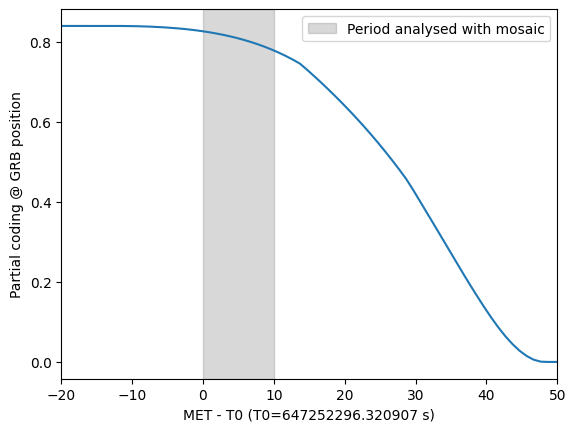

In [10]:
import swiftbat

object_batsource = swiftbat.source(
    ra=object_location.ra.deg, dec=object_location.dec.deg, name='test'
)

time = event.attitude.time.value - t0*np.ones(len(event.attitude.time))

exposures = np.array(
    [object_batsource.exposure(ra=ra,
                               dec=dec, 
                               roll=roll)[0]
        for ra,dec,roll in zip(event.attitude.ra,event.attitude.dec,event.attitude.roll)
    ])

plt.plot(time,exposures/5200)
plt.xlim(-20,50)
plt.axvspan(min_time, max_time, color='gray', alpha=0.3, label="Period analysed with mosaic")
plt.legend()
plt.xlabel('MET - T0 (T0=%s s)' %t0)
plt.ylabel('Partial coding @ GRB position')

plt.savefig('pc.pdf', dpi=500)

In [11]:
event.apply_mask_weighting(ra=object_location.ra, dec=object_location.dec)

After applying the mask weighting, we build a lightcurve, specifying a equally spaced binning of 1024 s

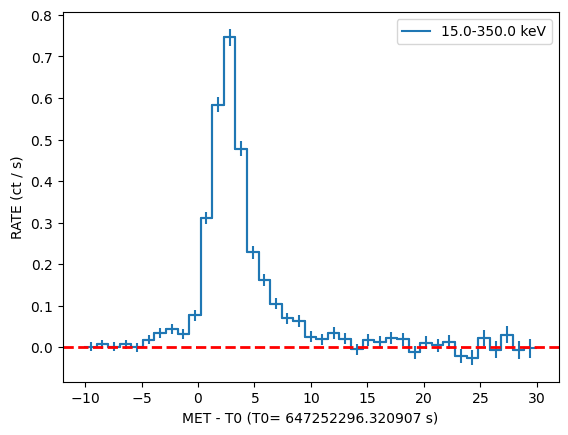

In [12]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV)
lc.set_timebins(
                timebinalg="uniform",
                timedelta=np.timedelta64(1024, 'ms'),
                tmin=-10*u.s,
                tmax=30*u.s,
                is_relative=True,
                T0=guano[0].triggertime.met)

lc.plot(T0=guano[0].triggertime.met, plot_relative=True)
plt.axhline(y=0.0, color='r', linestyle='--', linewidth=2)

plt.savefig('lc.pdf', dpi=500)

Same as above, but using Bayesian blocks

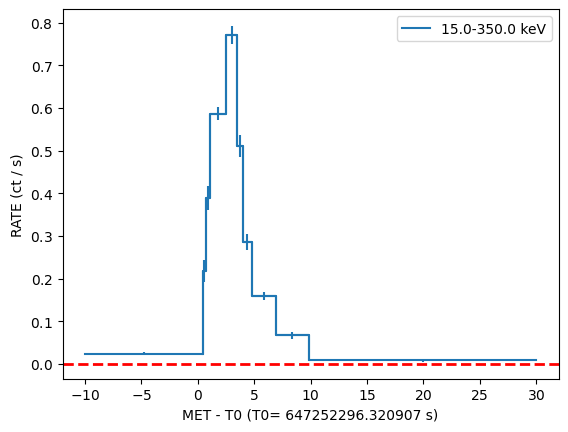

In [13]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV)
lc.set_timebins(timebinalg="bayesian", save_durations=True)
lc.plot(T0=guano[0].triggertime.met, plot_relative=True)
plt.axhline(y=0.0, color='r', linestyle='--', linewidth=2)



We then extract the spectrum for each temporal bin defined by the Bayesian blocks, using start and stop time of each bin

In [14]:
bayesian_spectra=event.create_pha(tstart=lc.tbins["TIME_START"], tstop=lc.tbins["TIME_STOP"])

We fit all the spectra using a power law

In [15]:
output_bayesian_spectra=ba.parallel.batspectrum_analysis(bayesian_spectra, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, nprocs=1, use_cstat=False, fit_iterations=10000, recalc=True)


1 spectrum  in use
 
Spectral Data File: t_647252286.3209069-647252296.752907_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.785e-02 +/- 4.884e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 10.43 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252286.3209069-647252296.752907_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -9.00000     +/-  0.0          
   4    2   powerlaw   PhoIndex            -1.00000     +/-  0.0          
   5    2   powerlaw   norm                1.00000E-03  frozen
________________________________________________________________________


Fit statistic  : Chi-Squared    

To obtain a time-averaged spectrum in the t90 interval, we concatenate DRM for each bin to obtain a final response function

In [16]:
spectrum_t90=event.create_pha(tstart=lc.tdurs['T90']['TSTART'], tstop=lc.tdurs['T90']['TSTOP'])

In [20]:
avg_drm=ba.BatDRM.concatenate([i.drm for i in output_bayesian_spectra], weights=lc.data["TOTCOUNTS"]/np.sum(lc.data["TOTCOUNTS"]), drm_save_file=spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp"))


1 spectrum  in use
 
Spectral Data File: t_647252297.200907-647252303.472907_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.420e-01 +/- 2.455e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 6.272 sec
 Using fit statistic: cstat
 Using Response (RMF) File            avg_drm.rsp for Source 1


Fit statistic  : C-Statistic                    2.56     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 1361.74     using 80 bins.
 Null hypothesis probability of 7.71e-233 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -9.00000    

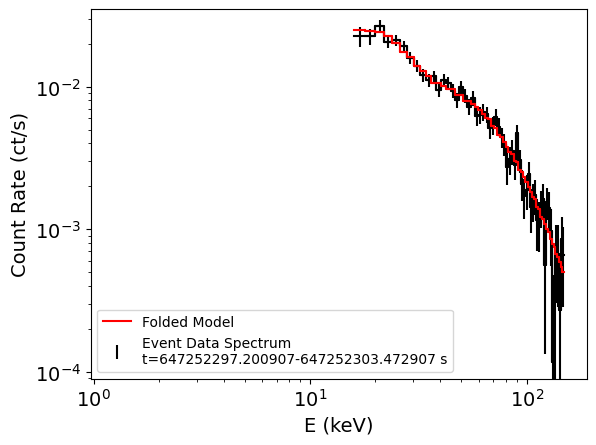

In [21]:
spectrum_t90.drm_file=spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp")

ba.fit_spectrum(spectrum_t90, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, use_cstat=False, fit_iterations=10000)

Here we plot the folded spectrum and relative best fit model, in the t90 time interval

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

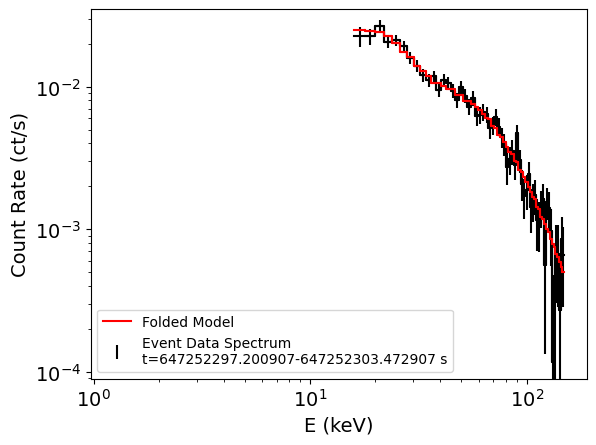

In [22]:
spectrum_t90.plot()

The result of the fit can be visualized in the form of a dictionary

In [23]:
spectrum_t90.spectral_model

{'parameters': {'Emin': {'val': 15.0,
   'lolim': 0.0,
   'hilim': 0.0,
   'errflag': 'FFFFFTFFF'},
  'Emax': {'val': 150.0, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'},
  'lg10Flux': {'val': -6.612187771267726,
   'lolim': -6.627339417455877,
   'hilim': -6.597510977437945,
   'errflag': 'FFFFFFFFF'},
  'PhoIndex': {'val': 1.5889098349823367,
   'lolim': 1.5269171430187012,
   'hilim': 1.6512292564667244,
   'errflag': 'FFFFFFFFF'},
  'norm': {'val': 0.001, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'}},
 'data': {'model_spectrum': <Quantity [0.02482776, 0.02474395, 0.02408308, 0.02253735, 0.02012026,
             0.01738699, 0.01624943, 0.01385091, 0.01292296, 0.01184455,
             0.01067205, 0.01062866, 0.01004273, 0.00963689, 0.00963501,
             0.00872809, 0.00873723, 0.00794411, 0.00797682, 0.00761124,
             0.00724999, 0.00680901, 0.00642131, 0.00603123, 0.00590696,
             0.00529085, 0.00514123, 0.00455972, 0.00441594, 0.00408684,
           

In order to visualize the results of the time-resolved spectral analysis, we concatenate the output of the spectral analysis of the Bayesian blocks

In [24]:
from batanalysis.batlib import concatenate_spectrum_data

spect_data = concatenate_spectrum_data(output_bayesian_spectra, ["flux", "phoindex"])

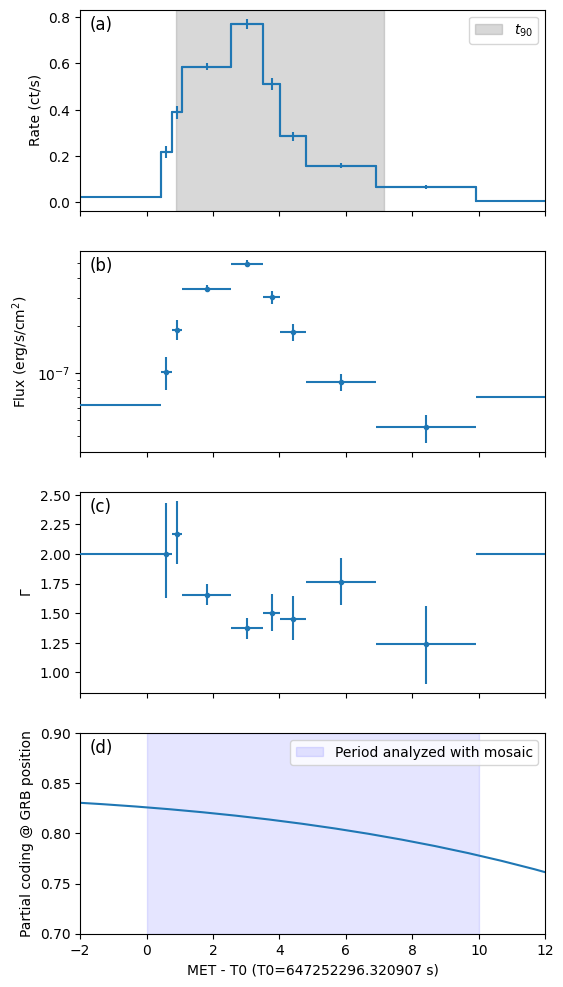

In [26]:
fig, axes = plt.subplots(4, sharex=True, figsize=(6, 12))



start_times = lc.tbins["TIME_START"]-t0*u.s
end_times = lc.tbins["TIME_STOP"]-t0*u.s
mid_times = lc.tbins["TIME_CENT"]-t0*u.s

rate = lc.data['RATE']
rate_error = lc.data["ERROR"]
        
line = axes[0].plot(start_times, rate, ds='steps-post')
line_handle, = axes[0].plot(end_times, rate, ds='steps-pre', color=line[-1].get_color())

flux = spect_data['flux']
flux_lolim = spect_data['flux_lolim']
flux_hilim = spect_data['flux_hilim']

axes[0].errorbar(mid_times, rate, yerr=rate_error, ls='None', color=line[-1].get_color())
axes[0].set_ylabel('Rate (ct/s)')



axes[0].axvspan(lc.tdurs['T90']['TSTART'].value-t0, lc.tdurs['T90']['TSTOP'].value-t0, color='gray', alpha=0.3, label="$t_{90}$")

axes[0].legend()

spec_param = 'flux'

y = spect_data[spec_param]

# get the errors
lolim = spect_data[f"{spec_param}_lolim"]
hilim = spect_data[f"{spec_param}_hilim"]

yerr = np.array([lolim, hilim])
y_upperlim = spect_data[f"{spec_param}_upperlim"]

# find where we have upper limits and set the error to 1 since the nan error value isnt
# compatible with upperlimits
yerr[:, y_upperlim] = 0.2 * y[y_upperlim]

tbin_cent = 0.5 * (spect_data["TIME_START"] + spect_data["TIME_STOP"])
tbin_err = 0.5 * (spect_data["TIME_STOP"] - spect_data["TIME_START"])

axes[1].errorbar(
    tbin_cent-t0*u.s,
    y,
    xerr=tbin_err,
    yerr=yerr,
    uplims=y_upperlim,
    linestyle="None",
    marker="o",
    markersize=3,
    zorder=3,
)  # color="red"

axes[1].set_ylabel('Flux ($ \\rm erg/s/cm^2$)')
axes[1].set_yscale('log')

spec_param = 'phoindex'

y = spect_data[spec_param]

# get the errors
lolim = spect_data[f"{spec_param}_lolim"]
hilim = spect_data[f"{spec_param}_hilim"]

yerr = np.array([lolim, hilim])
y_upperlim = spect_data[f"{spec_param}_upperlim"]

axes[2].errorbar(
    tbin_cent-t0*u.s,
    y,
    xerr=tbin_err,
    yerr=yerr,
    uplims=y_upperlim,
    linestyle="None",
    marker="o",
    markersize=3,
    zorder=3,
)  # color="red"

axes[2].set_ylabel('$\\Gamma$')

import swiftbat

object_batsource = swiftbat.source(
    ra=object_location.ra.deg, dec=object_location.dec.deg, name='test'
)

time = event.attitude.time.value - t0*np.ones(len(event.attitude.time))

exposures = np.array(
    [object_batsource.exposure(ra=ra,
                               dec=dec, 
                               roll=roll)[0]
        for ra,dec,roll in zip(event.attitude.ra,event.attitude.dec,event.attitude.roll)
    ])

axes[3].plot(time,exposures/5200)
axes[3].axvspan(min_time, max_time, color='blue', alpha=0.1, label="Period analyzed with mosaic")
axes[3].legend()
axes[3].set_xlabel('MET - T0 (T0=%s s)' %t0)
axes[3].set_ylabel('Partial coding @ GRB position')

axes[3].set_xlim(-2,12)
axes[3].set_ylim(0.7,0.9)

axes[0].text(
    0.02, 0.9, "(a)", transform=axes[0].transAxes, fontsize=12)  # Top-left of panel a
axes[1].text(
    0.02, 0.9, "(b)", transform=axes[1].transAxes, fontsize=12)  # Top-left of panel b
axes[2].text(
    0.02, 0.9, "(c)", transform=axes[2].transAxes, fontsize=12)  # Top-left of panel a
axes[3].text(
    0.02, 0.9, "(d)", transform=axes[3].transAxes, fontsize=12)  # Top-left of panel b

plt.savefig('combo.pdf', dpi=500)

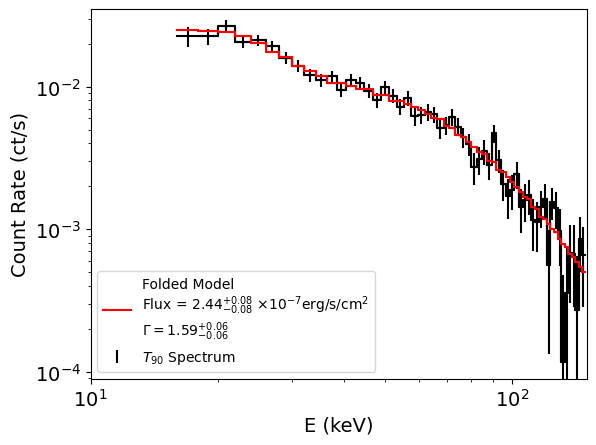

In [34]:
plot_model = True

emin=15 * u.keV
emax=150 * u.keV
self = spectrum_t90

# calculate the center of the energy bin
ecen = 0.5 * (self.ebins["E_MIN"] + self.ebins["E_MAX"])

# get where the energy is >15 keV and <195 keV
if emin is not None and emax is not None:
    energy_idx = np.where((self.ebins["E_MIN"] >= emin) & (self.ebins["E_MAX"] < emax))
else:
    energy_idx = np.where((self.ebins["E_MIN"] > -1 * np.inf) & (self.ebins["E_MAX"] < np.inf))

# calculate error including both systematic error and statistical error, note that systematic error has
# been multiplied by the rates/counts in the _parse_pha method
tot_error = np.sqrt(self.data["STAT_ERR"].value ** 2 + self.data["SYS_ERR"].value ** 2)

# get the quantity to be plotted
if "RATE" in self.data.keys():
    plot_data = self.data["RATE"]
else:
    plot_data = self.data["COUNTS"]

fig, ax = plt.subplots(1)
ax.loglog(self.ebins["E_MIN"][energy_idx], plot_data[energy_idx], color="k", drawstyle="steps-post")
ax.loglog(self.ebins["E_MAX"][energy_idx], plot_data[energy_idx], color="k", drawstyle="steps-pre")
ax.errorbar(
    ecen[energy_idx],
    plot_data[energy_idx],
    yerr=tot_error[energy_idx] * plot_data.unit,
    color="k",
    marker="None",
    ls="None",
    label="$T_{90}$ Spectrum",
)

if "RATE" in self.data.keys():
    ax.set_ylabel("Count Rate (ct/s)", fontsize=14)
else:
    ax.set_ylabel("Counts (ct)", fontsize=14)
ax.set_xlabel("E (keV)", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=14)

# if there is a fitted model need to get that and plot it
if self.spectral_model is not None and plot_model:
    model_emin = self.spectral_model["ebins"]["E_MIN"]
    model_emax = self.spectral_model["ebins"]["E_MAX"]

    # get where the energy is >15 keV and <195 keV
    if emin is not None and emax is not None:
        energy_idx = np.where((model_emin >= emin) & (model_emax < emax))
    else:
        energy_idx = np.where((model_emin > -1 * np.inf) & (model_emax < np.inf))

    model = self.spectral_model["data"]["model_spectrum"][energy_idx]

    ax.loglog(model_emin[energy_idx], model, color="r", drawstyle="steps-post")
    flux = 10**(spectrum_t90.spectral_model['parameters']['lg10Flux']['val'])
    flux_e_neg = flux - 10**spectrum_t90.spectral_model['parameters']['lg10Flux']['lolim']
    flux_e_pos = 10**spectrum_t90.spectral_model['parameters']['lg10Flux']['hilim'] - flux
    flux/=1e-7
    flux_e_neg/=1e-7
    flux_e_pos/=1e-7
    ga = spectrum_t90.spectral_model['parameters']['PhoIndex']['val']
    ga_e_neg = ga - spectrum_t90.spectral_model['parameters']['PhoIndex']['lolim']
    ga_e_pos = spectrum_t90.spectral_model['parameters']['PhoIndex']['hilim'] - ga
ax.loglog(
    model_emax[energy_idx], 
    model, 
    color="r", 
    drawstyle="steps-pre", 
    label=(
        f"Folded Model\n"
        f"Flux = ${flux:.2f}^{{+{flux_e_pos:.2f}}}_{{-{flux_e_neg:.2f}}}$ "
        f"$\\times 10^{{-7}} \\rm{{erg/s/cm^2}}$\n"
        f"$\\Gamma = {ga:.2f}^{{+{ga_e_pos:.2f}}}_{{-{ga_e_neg:.2f}}}$"
    )
)
ax.legend(loc="lower left")
ax.set_xlim(10,150)

plt.savefig('spe_t90.pdf', dpi=500)
